In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('predictive/drugoverdose.csv')

In [2]:
df.head()

,State,Year,Month,Period,Indicator,Data Value,Percent Complete,Percent Pending Investigation,State Name,Footnote,Footnote Symbol,Predicted Value,YearOverdoseNo,YearDeathsNo,%ofoverdose,%ofyeardeaths
0,AK,2015,November,12 month-ending,Heroin (T40.1),34,100,0.0,Alaska,Numbers may differ from published reports usin...,**,34,115,4219,29.57,0.81
1,AK,2015,November,12 month-ending,Natural & semi-synthetic opioids (T40.2),48,100,0.0,Alaska,Numbers may differ from published reports usin...,**,48,115,4219,41.74,1.14
2,AK,2015,November,12 month-ending,Methadone (T40.3),10,100,0.0,Alaska,Numbers may differ from published reports usin...,**,11,115,4219,8.70,0.24
3,AK,2015,November,12 month-ending,Psychostimulants with abuse potential (T43.6),26,100,0.0,Alaska,Numbers may differ from published reports usin...,**,27,115,4219,22.61,0.62
4,AK,2015,November,12 month-ending,"Synthetic opioids, excl. methadone (T40.4)",15,100,0.0,Alaska,Numbers may differ from published reports usin...,**,15,115,4219,13.04,0.36


In [3]:
df.dtypes

State                             object
Year                               int64
Month                             object
Period                            object
Indicator                         object
Data Value                         int64
Percent Complete                   int64
Percent Pending Investigation    float64
State Name                        object
Footnote                          object
Footnote Symbol                   object
Predicted Value                   object
YearOverdoseNo                     int64
YearDeathsNo                       int64
%ofoverdose                      float64
%ofyeardeaths                    float64
dtype: object

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean Squared Error (Random Forest): 943.1379442702051
R-squared (Random Forest): 0.9980040405784482


<Figure size 1200x600 with 0 Axes>

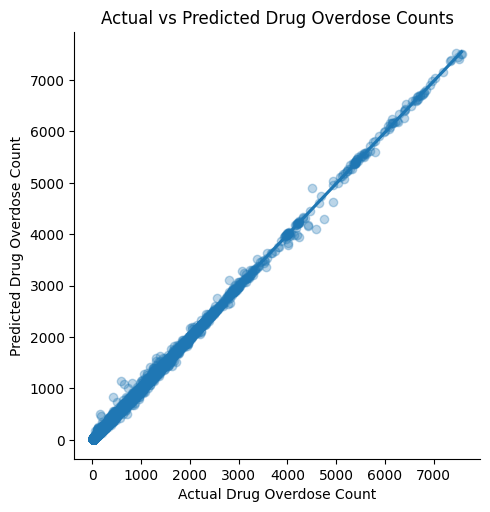

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('predictive/drugoverdose.csv')

# Feature Engineering
le_state = LabelEncoder()
le_month = LabelEncoder()
le_indicator = LabelEncoder()

df['StateEncoded'] = le_state.fit_transform(df['State'])
df['MonthEncoded'] = le_month.fit_transform(df['Month'])
df['IndicatorEncoded'] = le_indicator.fit_transform(df['Indicator'])

# Splitting data
X = df[['StateEncoded', 'Year', 'MonthEncoded', 'IndicatorEncoded', 'YearOverdoseNo', 'YearDeathsNo']]
y = df['Data Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_

# Model training with best hyperparameters
model_rf = RandomForestRegressor(**best_params, random_state=42)
model_rf.fit(X_train, y_train)

# Model evaluation
y_pred_rf = model_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Best Hyperparameters: {best_params}')
print(f'Mean Squared Error (Random Forest): {mse_rf}')
print(f'R-squared (Random Forest): {r2_rf}')

# Make predictions for the entire dataset
df['Predicted Drug Overdose Count (Random Forest)'] = model_rf.predict(X)

# Smoother Visualization with lmplot
plt.figure(figsize=(12, 6))
sns.lmplot(x='Data Value', y='Predicted Drug Overdose Count (Random Forest)', data=df, scatter_kws={'alpha':0.3})
plt.title('Actual vs Predicted Drug Overdose Counts')
plt.xlabel('Actual Drug Overdose Count')
plt.ylabel('Predicted Drug Overdose Count')
plt.show()

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
import time

# Load the data
df = pd.read_csv('predictive\drugoverdose.csv')

# Convert 'Month' to string
df['Month'] = df['Month'].astype(str)

# Compute threshold for binary classification
threshold = df['Data Value'].median()
df['OverdoseResult'] = (df['Data Value'] > threshold).astype(int)

# Selecting features and target variable
X = df[['Year', 'Month', 'State', 'Data Value', 'Percent Complete', 'Percent Pending Investigation']]
y = df['Indicator']

In [3]:
# Convert categorical target variable to numeric
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2, random_state=42)

# Identify categorical columns and numeric columns
categorical_columns = ['Month', 'State']
numeric_columns = ['Year', 'Data Value', 'Percent Complete', 'Percent Pending Investigation']

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))  # Set sparse=False
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

In [4]:
# Models
models = {
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest Classifier': RandomForestClassifier(random_state=42),
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'XGBoost': xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss"),
    'DNN': MLPClassifier(hidden_layer_sizes=(100,), max_iter=300)
}

# Initialize dictionaries to store evaluation metrics for each model
accuracies = {}
algo_time = {}
r2_scores = {}
mean_squared_errors = {}
roc_auc_scores = {}

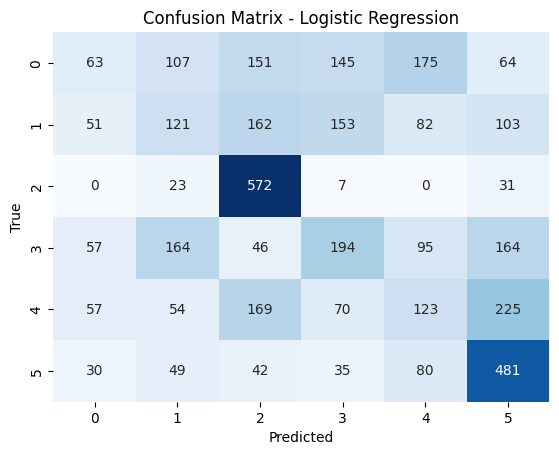

Classification Report - Logistic Regression:
               precision    recall  f1-score   support

           0       0.24      0.09      0.13       705
           1       0.23      0.18      0.20       672
           2       0.50      0.90      0.64       633
           3       0.32      0.27      0.29       720
           4       0.22      0.18      0.20       698
           5       0.45      0.67      0.54       717

    accuracy                           0.37      4145
   macro avg       0.33      0.38      0.33      4145
weighted avg       0.33      0.37      0.33      4145



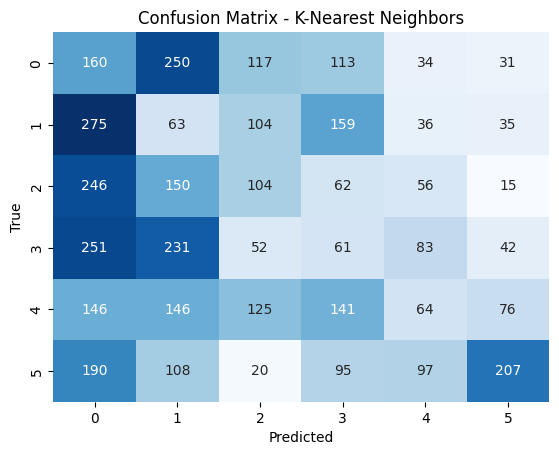

Classification Report - K-Nearest Neighbors:
               precision    recall  f1-score   support

           0       0.13      0.23      0.16       705
           1       0.07      0.09      0.08       672
           2       0.20      0.16      0.18       633
           3       0.10      0.08      0.09       720
           4       0.17      0.09      0.12       698
           5       0.51      0.29      0.37       717

    accuracy                           0.16      4145
   macro avg       0.20      0.16      0.17      4145
weighted avg       0.20      0.16      0.17      4145



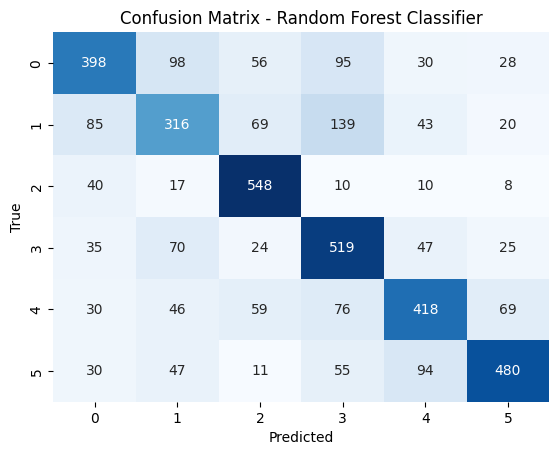

Classification Report - Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.64      0.56      0.60       705
           1       0.53      0.47      0.50       672
           2       0.71      0.87      0.78       633
           3       0.58      0.72      0.64       720
           4       0.65      0.60      0.62       698
           5       0.76      0.67      0.71       717

    accuracy                           0.65      4145
   macro avg       0.65      0.65      0.64      4145
weighted avg       0.65      0.65      0.64      4145



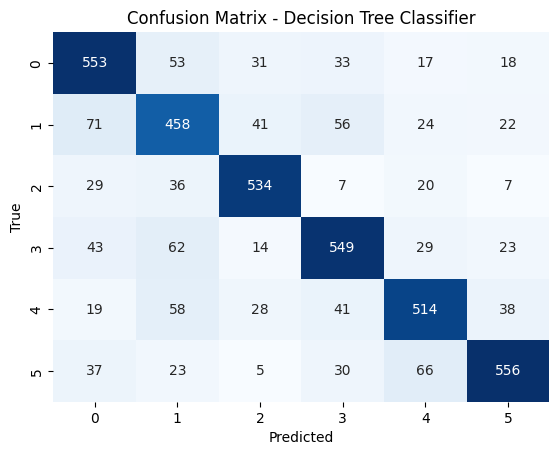

Classification Report - Decision Tree Classifier:
               precision    recall  f1-score   support

           0       0.74      0.78      0.76       705
           1       0.66      0.68      0.67       672
           2       0.82      0.84      0.83       633
           3       0.77      0.76      0.76       720
           4       0.77      0.74      0.75       698
           5       0.84      0.78      0.81       717

    accuracy                           0.76      4145
   macro avg       0.76      0.76      0.76      4145
weighted avg       0.76      0.76      0.76      4145



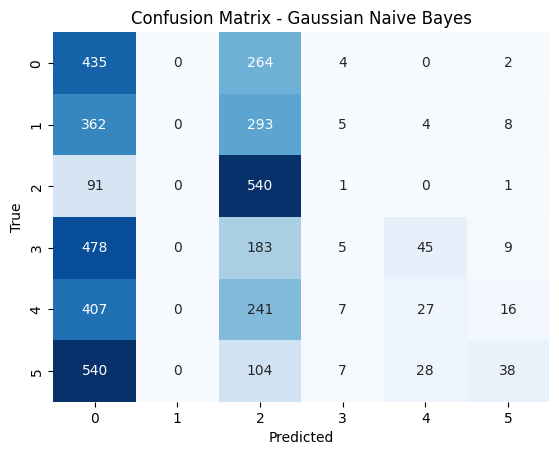

Classification Report - Gaussian Naive Bayes:
               precision    recall  f1-score   support

           0       0.19      0.62      0.29       705
           1       0.00      0.00      0.00       672
           2       0.33      0.85      0.48       633
           3       0.17      0.01      0.01       720
           4       0.26      0.04      0.07       698
           5       0.51      0.05      0.10       717

    accuracy                           0.25      4145
   macro avg       0.24      0.26      0.16      4145
weighted avg       0.25      0.25      0.15      4145



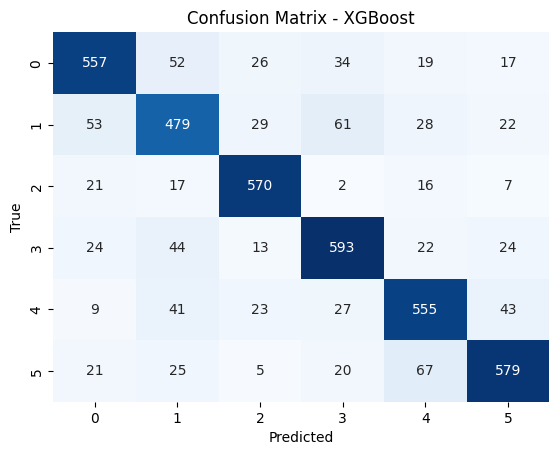

Classification Report - XGBoost:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80       705
           1       0.73      0.71      0.72       672
           2       0.86      0.90      0.88       633
           3       0.80      0.82      0.81       720
           4       0.79      0.80      0.79       698
           5       0.84      0.81      0.82       717

    accuracy                           0.80      4145
   macro avg       0.80      0.80      0.80      4145
weighted avg       0.80      0.80      0.80      4145



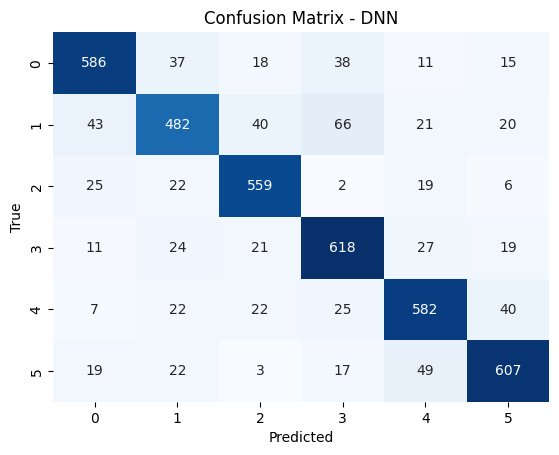

Classification Report - DNN:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84       705
           1       0.79      0.72      0.75       672
           2       0.84      0.88      0.86       633
           3       0.81      0.86      0.83       720
           4       0.82      0.83      0.83       698
           5       0.86      0.85      0.85       717

    accuracy                           0.83      4145
   macro avg       0.83      0.83      0.83      4145
weighted avg       0.83      0.83      0.83      4145



In [5]:
# Train and evaluate each model
for model_name, model in models.items():
    start_time = time.time()  # Start time for calculating algorithm time
    
    # Pipeline with classifier
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', model)])

    # Hyperparameter tuning using GridSearchCV
    if model_name in ['Random Forest Classifier', 'XGBoost']:
        param_grid = {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [None, 10, 20],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4]
        }
    elif model_name == 'K-Nearest Neighbors':
        param_grid = {
            'classifier__n_neighbors': [3, 5, 7],
            'classifier__weights': ['uniform', 'distance'],
            'classifier__p': [1, 2]
        }
    elif model_name == 'Decision Tree Classifier':
        param_grid = {
            'classifier__max_depth': [None, 10, 20],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4]
        }
    elif model_name == 'XGBoost':
        param_grid = {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [3, 6, 9],
            'classifier__learning_rate': [0.01, 0.1, 0.2]
        }
    elif model_name == 'DNN':
        param_grid = {
            'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
            'classifier__max_iter': [100, 200, 300],
        }
    else:  # Logistic Regression and Gaussian Naive Bayes
        param_grid = {}  # Use default hyperparameters

    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model
    best_model = grid_search.best_estimator_

    # Model Evaluation with Confusion Matrix and Classification Report
    predictions = best_model.predict(X_test)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, predictions)

    # Plot confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # Classification report
    class_report = classification_report(y_test, predictions)
    print(f'Classification Report - {model_name}:\n', class_report)

    # Binarize the labels
    y_test_binarized = label_binarize(y_test, classes=best_model.classes_)

    # Compute ROC curve and ROC area for each class
    roc_auc_values = {}
    for i, drug_class in enumerate(best_model.classes_):
        class_probabilities = best_model.predict_proba(X_test)[:, i]
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], class_probabilities)
        roc_auc = auc(fpr, tpr)
        roc_auc_values[drug_class] = roc_auc

    # Store evaluation metrics for the model
    accuracies[model_name] = best_model.score(X_test, y_test)
    algo_time[model_name] = time.time() - start_time
    r2_scores[model_name] = best_model.score(X_test, y_test)
    mean_squared_errors[model_name] = np.mean((predictions - y_test) ** 2)
    roc_auc_scores[model_name] = roc_auc_values

In [6]:
# Print the evaluation metrics
print("Accuracies:", accuracies)
print("Algorithm Time:", algo_time)
print("R2 Scores:", r2_scores)
print("Mean Squared Errors:", mean_squared_errors)
print("ROC AUC Scores:", roc_auc_scores)

Accuracies: {'Logistic Regression': 0.3749095295536791, 'K-Nearest Neighbors': 0.15898673100120628, 'Random Forest Classifier': 0.6463208685162847, 'Decision Tree Classifier': 0.763329312424608, 'Gaussian Naive Bayes': 0.25211097708082025, 'XGBoost': 0.8041013268998793, 'DNN': 0.8284680337756333}
Algorithm Time: {'Logistic Regression': 7.6141064167022705, 'K-Nearest Neighbors': 21.877070903778076, 'Random Forest Classifier': 101.8069396018982, 'Decision Tree Classifier': 2.4607629776000977, 'Gaussian Naive Bayes': 0.48595213890075684, 'XGBoost': 132.4741246700287, 'DNN': 191.97142481803894}
R2 Scores: {'Logistic Regression': 0.3749095295536791, 'K-Nearest Neighbors': 0.15898673100120628, 'Random Forest Classifier': 0.6463208685162847, 'Decision Tree Classifier': 0.763329312424608, 'Gaussian Naive Bayes': 0.25211097708082025, 'XGBoost': 0.8041013268998793, 'DNN': 0.8284680337756333}
Mean Squared Errors: {'Logistic Regression': 3.95729794933655, 'K-Nearest Neighbors': 5.186007237635706, 

In [7]:
# Visualizations
import plotly.express as px
import plotly.graph_objects as go

# Accuracy Comparison
fig_accuracy = px.bar(x=list(accuracies.keys()), y=list(accuracies.values()))
fig_accuracy.update_traces(marker_color='teal', marker_line_color='rgb(8,48,107)', marker_line_width=1.5)
fig_accuracy.update_layout(title="Accuracy Comparison", xaxis_title="Model", yaxis_title="Accuracy")
fig_accuracy.show()

# Algorithm Time Comparison
fig_algorithm_time = px.bar(x=list(algo_time.keys()), y=list(algo_time.values()))
fig_algorithm_time.update_traces(marker_color='teal', marker_line_color='rgb(8,48,107)', marker_line_width=1.5)
fig_algorithm_time.update_layout(title="Algorithm Time Comparison", xaxis_title="Model", yaxis_title="")
fig_algorithm_time.show()

# R2 Score Comparison
fig_r2_scores = px.bar(x=list(r2_scores.keys()), y=list(r2_scores.values()))
fig_r2_scores.update_traces(marker_color='teal', marker_line_color='rgb(8,48,107)', marker_line_width=1.5)
fig_r2_scores.update_layout(title="R2 Score Comparison", xaxis_title="Model", yaxis_title="R2 Scores")
fig_r2_scores.show()

# Mean Squared Error Comparison
fig_mse = px.bar(x=list(mean_squared_errors.keys()), y=list(mean_squared_errors.values()))
fig_mse.update_traces(marker_color='teal', marker_line_color='rgb(8,48,107)', marker_line_width=1.5)
fig_mse.update_layout(title="Mean Squared Error Comparison", xaxis_title="Model", yaxis_title="Mean Squared Error")
fig_mse.show()

# ROC Score Comparison
fig_roc_auc = go.Figure()

for drug_class, data in roc_auc_scores.items():
    fig_roc_auc.add_trace(go.Bar(name=drug_class, x=list(data.keys()), y=list(data.values())))

fig_roc_auc.update_traces(marker_color='teal', marker_line_color='rgb(8,48,107)', marker_line_width=1.5)
fig_roc_auc.update_layout(title="ROC Score Comparison", xaxis_title="Model", yaxis_title="ROC Scores", barmode='group')
fig_roc_auc.show()

# Combined Comparison
combined_fig = go.Figure(data=[
    go.Bar(name='Accuracies', x=list(accuracies.keys()), y=list(accuracies.values())),
    go.Bar(name='R2 Scores', x=list(r2_scores.keys()), y=list(r2_scores.values())),
    go.Bar(name='Mean Squared Errors', x=list(mean_squared_errors.keys()), y=list(mean_squared_errors.values())),
    # *[
    #     go.Bar(name=f'{drug_class} ROC AUC', x=list(roc_auc_scores[drug_class].keys()), y=list(roc_auc_scores[drug_class].values()))
    #     for drug_class in roc_auc_scores.keys()
    # ]
])

# Change the bar mode
combined_fig.update_layout(barmode='group')
combined_fig.show()


Epoch 1/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 385928.1250 - val_loss: 193823.7656
Epoch 2/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 162790.0469 - val_loss: 111617.2500
Epoch 3/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 96411.5156 - val_loss: 70482.2188
Epoch 4/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 63892.9570 - val_loss: 52067.9062
Epoch 5/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 51006.7656 - val_loss: 46026.7422
Epoch 6/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 44075.8984 - val_loss: 41259.8047
Epoch 7/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 39160.6758 - val_loss: 39979.5039
Epoch 8/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 39661.1289 - val_loss: 41074.9727
Epoch 9/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 38016.0469 - val_loss: 34567.1875
Epoch 10/200
519/519 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 36711.1562 - val_loss: 33797.3047
Epoch 11/200
519/519 ━━━━━━━━━━━━

<Figure size 1200x600 with 0 Axes>

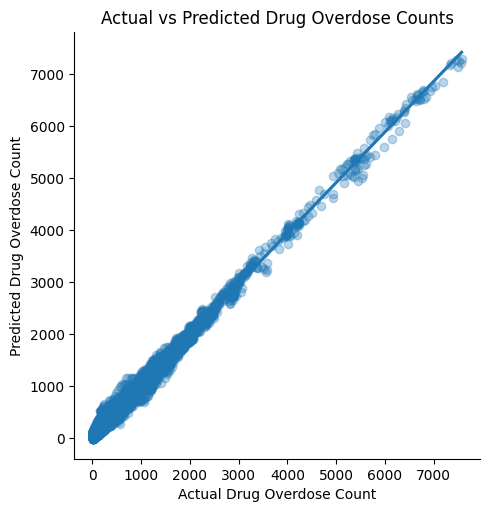

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load the dataset
df = pd.read_csv('predictive/drugoverdose.csv')

# Feature Engineering
le_state = LabelEncoder()
le_month = LabelEncoder()
le_indicator = LabelEncoder()

df['StateEncoded'] = le_state.fit_transform(df['State'])
df['MonthEncoded'] = le_month.fit_transform(df['Month'])
df['IndicatorEncoded'] = le_indicator.fit_transform(df['Indicator'])

# Splitting data
X = df[['StateEncoded', 'Year', 'MonthEncoded', 'IndicatorEncoded', 'YearOverdoseNo', 'YearDeathsNo']]
y = df['Data Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the DNN model
model_dnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer
])

# Compile the model
model_dnn.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_dnn.fit(X_train_scaled, y_train, epochs=200, batch_size=32, validation_data=(X_test_scaled, y_test), )

# Model evaluation
y_pred_dnn = model_dnn.predict(X_test_scaled).flatten()
mse_dnn = mean_squared_error(y_test, y_pred_dnn)
r2_dnn = r2_score(y_test, y_pred_dnn)

print(f'Mean Squared Error (DNN): {mse_dnn}')
print(f'R-squared (DNN): {r2_dnn}')

# Make predictions for the entire dataset
df['Predicted Drug Overdose Count (DNN)'] = model_dnn.predict(scaler.transform(X)).flatten()

# Smoother Visualization with lmplot
plt.figure(figsize=(12, 6))
sns.lmplot(x='Data Value', y='Predicted Drug Overdose Count (DNN)', data=df, scatter_kws={'alpha':0.3})
plt.title('Actual vs Predicted Drug Overdose Counts')
plt.xlabel('Actual Drug Overdose Count')
plt.ylabel('Predicted Drug Overdose Count')
plt.show()